In [156]:
%reload_ext autoreload
%autoreload 2
import ast
import pickle
import itertools
from collections import Counter
from tqdm import tqdm
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 
import cv2
import swifter
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances

import sys
sys.path.append('..')

from analysis.generate_cluster_information_file import load, extract_all_information_query, to_df_query
from common.image_processing import pixel_intensity_histogram

In [6]:
df = load()
df.head(5)

,score,background_threshold,cluster_num,cluster_sizes,cluster_peak_intensities,cluster_num_intensities,cluster_centers
id,,,,,,,
1002900,2.631728,0,50,"[144, 38, 24, 16, 5, 39, 17, 18, 26, 11, 56, 1...","[6, 6, 2, 2, 1, 8, 2, 1, 3, 1, 3, 2, 255, 2, 6...","[6, 6, 2, 2, 1, 7, 2, 1, 3, 1, 3, 2, 71, 2, 6,...","[(3, 524), (44, 425), (55, 321), (66, 400), (9..."
1003620,1.560731,0,104,"[28, 17, 8, 11, 45, 4, 14, 71, 1, 7, 2, 18, 11...","[4, 2, 1, 2, 9, 1, 2, 16, 1, 1, 1, 3, 1, 1, 1,...","[4, 2, 1, 2, 8, 1, 2, 14, 1, 1, 1, 3, 1, 1, 1,...","[(19, 375), (53, 839), (56, 524), (84, 208), (..."
1005208,3.137059,1,71,"[53, 27, 42, 6, 3, 15, 19, 45, 73, 115, 119, 6...","[12, 4, 9, 2, 2, 2, 3, 4, 9, 68, 78, 2, 2, 2, ...","[10, 3, 8, 1, 1, 1, 2, 3, 8, 31, 34, 1, 1, 1, ...","[(3, 582), (0, 715), (14, 83), (19, 614), (51,..."
1005849,3.509851,2,49,"[1, 5, 61, 4, 80, 45, 68, 44, 10, 35, 28, 7, 3...","[3, 3, 12, 3, 69, 15, 12, 17, 3, 4, 5, 3, 3, 3...","[1, 1, 10, 1, 27, 8, 9, 13, 1, 2, 3, 1, 1, 1, ...","[(0, 906), (0, 949), (5, 508), (24, 591), (34,..."
1006237,1.371129,0,169,"[3, 92, 6, 138, 16, 12, 142, 6, 31, 1, 11, 3, ...","[1, 179, 1, 255, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1,...","[1, 41, 1, 47, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1, 2...","[(0, 604), (2, 736), (13, 155), (26, 601), (22..."


In [7]:
# pd saves lists as strings, so we need to convert them to lists manually
df.cluster_sizes = df.cluster_sizes.swifter.apply(ast.literal_eval)
df.cluster_centers = df.cluster_centers.swifter.apply(ast.literal_eval)
df.cluster_peak_intensities = df.cluster_peak_intensities.swifter.apply(ast.literal_eval)
df.cluster_num_intensities = df.cluster_num_intensities.swifter.apply(ast.literal_eval)

assert type(df.cluster_sizes.tolist()[0]) == list

df.head(10)

,score,background_threshold,cluster_num,cluster_sizes,cluster_peak_intensities,cluster_num_intensities,cluster_centers
id,,,,,,,
1002900,2.631728,0,50,"[144, 38, 24, 16, 5, 39, 17, 18, 26, 11, 56, 1...","[6, 6, 2, 2, 1, 8, 2, 1, 3, 1, 3, 2, 255, 2, 6...","[6, 6, 2, 2, 1, 7, 2, 1, 3, 1, 3, 2, 71, 2, 6,...","[(3, 524), (44, 425), (55, 321), (66, 400), (9..."
1003620,1.560731,0,104,"[28, 17, 8, 11, 45, 4, 14, 71, 1, 7, 2, 18, 11...","[4, 2, 1, 2, 9, 1, 2, 16, 1, 1, 1, 3, 1, 1, 1,...","[4, 2, 1, 2, 8, 1, 2, 14, 1, 1, 1, 3, 1, 1, 1,...","[(19, 375), (53, 839), (56, 524), (84, 208), (..."
1005208,3.137059,1,71,"[53, 27, 42, 6, 3, 15, 19, 45, 73, 115, 119, 6...","[12, 4, 9, 2, 2, 2, 3, 4, 9, 68, 78, 2, 2, 2, ...","[10, 3, 8, 1, 1, 1, 2, 3, 8, 31, 34, 1, 1, 1, ...","[(3, 582), (0, 715), (14, 83), (19, 614), (51,..."
1005849,3.509851,2,49,"[1, 5, 61, 4, 80, 45, 68, 44, 10, 35, 28, 7, 3...","[3, 3, 12, 3, 69, 15, 12, 17, 3, 4, 5, 3, 3, 3...","[1, 1, 10, 1, 27, 8, 9, 13, 1, 2, 3, 1, 1, 1, ...","[(0, 906), (0, 949), (5, 508), (24, 591), (34,..."
1006237,1.371129,0,169,"[3, 92, 6, 138, 16, 12, 142, 6, 31, 1, 11, 3, ...","[1, 179, 1, 255, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1,...","[1, 41, 1, 47, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1, 2...","[(0, 604), (2, 736), (13, 155), (26, 601), (22..."
1006576,1.472584,1,51,"[22, 14, 24, 83, 8, 6, 75, 2, 6, 69, 23, 201, ...","[5, 2, 5, 3, 2, 2, 38, 2, 2, 34, 3, 253, 3, 2,...","[4, 1, 4, 2, 1, 1, 24, 1, 1, 23, 2, 64, 2, 1, ...","[(11, 576), (55, 451), (57, 818), (152, 691), ..."
1007505,0.000595,191,2216,"[2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 1, 1, 1, 1, 1, ...","[194, 193, 194, 197, 195, 195, 196, 195, 198, ...","[2, 1, 2, 2, 2, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, ...","[(3, 150), (44, 125), (49, 50), (55, 45), (66,..."
1009094,2.872140,0,66,"[19, 2, 29, 1, 5, 52, 27, 10, 1, 30, 17, 4, 5,...","[3, 1, 4, 1, 1, 14, 1, 2, 1, 5, 1, 1, 1, 14, 2...","[3, 1, 4, 1, 1, 10, 1, 2, 1, 5, 1, 1, 1, 10, 7...","[(3, 676), (4, 684), (43, 551), (60, 123), (62..."
1010254,0.001556,9,73732,"[1, 3, 1, 1, 3, 9, 2, 1, 3, 4, 2, 1, 5, 1, 1, ...","[15, 13, 19, 14, 19, 16, 11, 29, 18, 18, 21, 1...","[1, 3, 1, 1, 3, 5, 1, 1, 3, 4, 2, 1, 5, 1, 1, ...","[(0, 7), (1, 11), (0, 19), (0, 23), (0, 25), (..."


### Background threshold
It seems that background threshold is predictive of score.
For low background thresholds, most of the images are concentrated with a score of 1-2.
By increasing the background threshold, less of the probability mass is concentrated in scores of 1-2, and more of it is in the 0-1 score interval

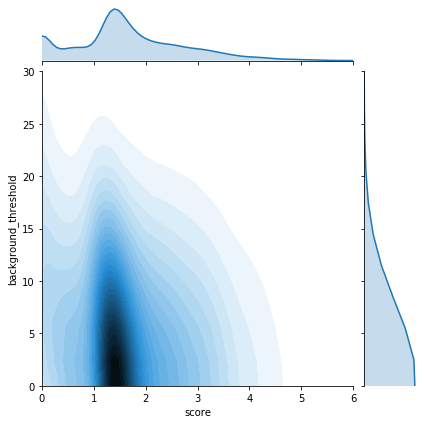

In [17]:
ax = sns.jointplot(x='score', y='background_threshold', data=df, kind='kde', xlim=(0, 6), ylim=((0, 30)), 
                   joint_kws={'n_levels': 30, 'shade': True, 'shade_lowest': False})
# ax.set_xlim((0, 50))
# ax.set_ylim((0, 6))

### Cluster number
Very similar distribution to background threshold

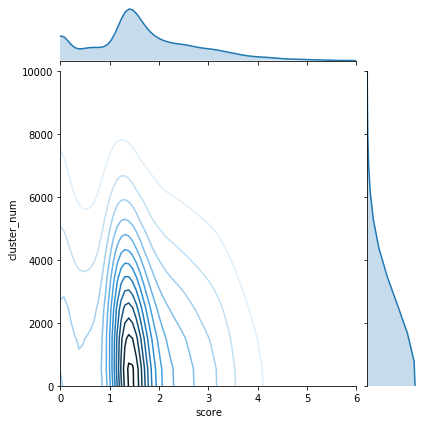

In [22]:
ax = sns.jointplot(x='score', y='cluster_num', data=df, kind='kde', xlim=(0, 6), ylim=((0, 10000)), 
                   joint_kws={'n_levels': 15, 'shade': False, 'shade_lowest': False})

In [24]:
low_cluster_num_df = df[df.cluster_num <= 300]
medium_cluster_num_df = df[(df.cluster_num <= 1500) & (df.cluster_num > 300)]
high_cluster_num_df = df[df.cluster_num > 1500]
low_cluster_num_df.shape[0], medium_cluster_num_df.shape[0], high_cluster_num_df.shape[0]

(7842, 649, 1109)

#### Small, medium and large number of clusters
Real images are defined by a "small" number of clusters. This plot shows that images with a medium and high number of clusters are mostly given scores close to 0, whereas images with small number of clusters are mostly given a score of 1-4

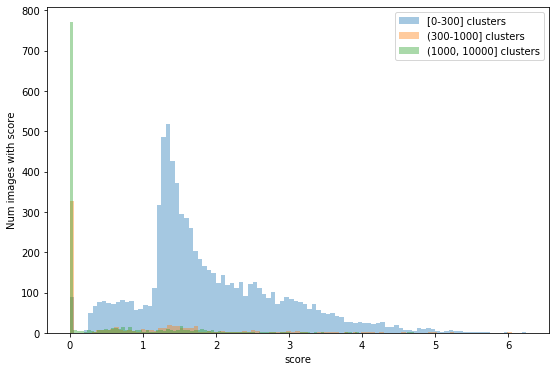

In [37]:
fig, ax1 = plt.subplots(1, 1)
ax1.figure.set_size_inches(9, 6)
ax1.set_ylabel("Num images with score")
sns.distplot(low_cluster_num_df.score, bins=100, hist=True, kde=False, rug=False, ax=ax1, label='[0-300] clusters')
sns.distplot(medium_cluster_num_df.score, bins=100, hist=True, kde=False, rug=False, ax=ax1, label='(300-1000] clusters')
sns.distplot(high_cluster_num_df.score, bins=100, hist=True, kde=False, rug=False, ax=ax1, label='(1000, 10000] clusters')
plt.legend()

In [168]:
def get_features(raw_df, score=True):
    data_df = raw_df.reset_index()
    feature_names = ['cluster_num', 'background_threshold',
                     'cluster_num_intensities_avg', 'cluster_num_intensities_max', 'cluster_num_intensities_min', 'cluster_num_intensities_std',
                     'cluster_peak_intensities_avg', 'cluster_peak_intensities_max', 'cluster_peak_intensities_min', 'cluster_peak_intensities_std', 
                     'cluster_sizes_avg', 'cluster_sizes_std', 'cluster_sizes_max', 'cluster_sizes_min', 'cluster_sizes_sum',
                     'cluster_x_avg', 'cluster_y_avg',
                     'cluster_dist_min', 'cluster_dist_max',
                     'largest_clusters_distance', 'brightest_clusters_distance']
    if score:
        feature_names.append('score')
    features = {name: np.empty(len(data_df.index), dtype='float') for name in feature_names}

    for i in tqdm(range(len(data_df.index))):
        features['cluster_num'][i] = data_df.at[i, 'cluster_num']
        features['background_threshold'][i] = data_df.at[i, 'background_threshold']
        if score:
            features['score'][i] = data_df.at[i, 'score']
    
        # not sure how, but for a single image there's no clusters, sweep it under the rug
        if features['cluster_num'][i] == 0:
            continue
            
        c_s = np.array(data_df.at[i,'cluster_sizes'])
        c_p_i = np.array(data_df.at[i,'cluster_peak_intensities'])
        c_n_i = np.array(data_df.at[i,'cluster_num_intensities'])
        features['cluster_sizes_avg'][i] = np.average(c_s)
        features['cluster_sizes_max'][i] = np.max(c_s)
        features['cluster_sizes_min'][i] = np.min(c_s)
        features['cluster_sizes_std'][i] = np.std(c_s)
        features['cluster_sizes_sum'][i] = np.sum(c_s)
        
        features['cluster_peak_intensities_avg'][i] = np.average(c_p_i)
        features['cluster_peak_intensities_max'][i] = np.max(c_p_i)
        features['cluster_peak_intensities_min'][i] = np.min(c_p_i)
        features['cluster_peak_intensities_std'][i] = np.std(c_p_i)
        
        features['cluster_num_intensities_avg'][i] = np.average(c_n_i)
        features['cluster_num_intensities_avg'][i] = np.max(c_n_i)
        features['cluster_num_intensities_avg'][i] = np.min(c_n_i)
        features['cluster_num_intensities_avg'][i] = np.std(c_n_i)

        cluster_centers = data_df.at[i, 'cluster_centers']
        temp_x = np.empty(int(features['cluster_num'][i]))
        temp_y = np.empty(int(features['cluster_num'][i]))
        for j in range(int(features['cluster_num'][i])):
            (x,y) = cluster_centers[j]
            temp_x[j] = x 
            temp_y[j] = y
        features['cluster_x_avg'][i] = np.average(temp_x)
        features['cluster_y_avg'][i] = np.average(temp_y)
        
        if features['cluster_num'][i] == 1: # cannot compare 2 largest when there is a single cluster
            features['largest_clusters_distance'][i] = 10000
            features['brightest_clusters_distance'][i] = 10000 
        elif features['cluster_num'][i] >= 3000: # too computationally expensive
            features['largest_clusters_distance'][i] = 1
            features['brightest_clusters_distance'][i] = 1
        else:
            distances = pairwise_distances(np.array(cluster_centers), n_jobs=-1)
            
            largest_clusters_ind = c_s.argsort()[-2:]
            brightest_clusters_ind = c_p_i.argsort()[-2:]
            features['largest_clusters_distance'][i] = distances[largest_clusters_ind[0], largest_clusters_ind[1]]
            features['brightest_clusters_distance'][i] = distances[brightest_clusters_ind[0], brightest_clusters_ind[1]]
        
        distances = distances[distances > 0]
        features['cluster_dist_min'][i] = np.min(distances)
        features['cluster_dist_max'][i] = np.max(distances)
            
            
        
    df_X = pd.DataFrame.from_dict(features)
    return df_X

In [169]:
df_X = get_features(df)
print(df_X.shape)
df_X.head(10)

100%|██████████████████████████████████████████████████████████████████████████████| 9600/9600 [05:00<00:00, 31.93it/s]

(9600, 22)


,cluster_num,background_threshold,cluster_num_intensities_avg,cluster_num_intensities_max,cluster_num_intensities_min,cluster_num_intensities_std,cluster_peak_intensities_avg,cluster_peak_intensities_max,cluster_peak_intensities_min,cluster_peak_intensities_std,...,cluster_sizes_max,cluster_sizes_min,cluster_sizes_sum,cluster_x_avg,cluster_y_avg,cluster_dist_min,cluster_dist_max,largest_clusters_distance,brightest_clusters_distance,score
0,50.0,0.0,13.844046,1.007997e-311,1.008275e-311,1.008275e-311,14.920000,255.0,1.0,49.370777,...,225.0,1.0,1779.0,513.460000,475.320000,19.235384,1251.265360,418.150691,418.150691,2.631728
1,104.0,0.0,11.164915,1.007929e-311,1.007929e-311,1.007929e-311,11.375000,255.0,1.0,36.751030,...,179.0,1.0,2926.0,536.201923,473.798077,17.204651,1223.943218,537.729486,605.561723,1.560731
2,71.0,1.0,12.496173,4.649718e+02,2.730000e+02,1.000000e+00,11.563380,255.0,2.0,34.161890,...,273.0,1.0,2426.0,464.971831,513.746479,24.041631,1235.969255,758.641549,841.503417,3.137059
3,49.0,2.0,13.074356,4.172857e+02,6.350000e+02,1.000000e+00,22.612245,255.0,3.0,51.612297,...,635.0,1.0,2628.0,417.285714,564.571429,13.601471,1243.556995,798.068919,257.670332,3.509851
4,169.0,0.0,6.639654,4.622249e+02,1.610000e+02,1.000000e+00,6.621302,255.0,1.0,26.394791,...,161.0,1.0,3469.0,462.224852,509.230769,2.000000,1319.351735,1064.421439,137.116739,1.371129
5,51.0,1.0,17.443819,5.909216e+02,2.360000e+02,1.000000e+00,26.921569,255.0,2.0,64.565772,...,236.0,1.0,2432.0,590.921569,492.352941,21.954498,1135.750853,344.653449,337.831319,1.472584
6,2216.0,191.0,4.407226,4.335695e+02,1.512920e+05,1.000000e+00,196.498195,254.0,192.0,6.801996,...,151292.0,1.0,192580.0,433.569495,468.828520,2.000000,1187.283454,646.561675,366.006831,0.000595
7,66.0,0.0,13.259619,4.502576e+02,2.630000e+02,1.000000e+00,15.045455,255.0,1.0,46.085044,...,263.0,1.0,1988.0,450.257576,427.469697,8.062258,1153.087161,267.029961,267.029961,2.872140
8,73732.0,9.0,1.713660,4.986155e+02,6.200000e+01,1.000000e+00,17.661884,255.0,10.0,5.843887,...,62.0,1.0,177887.0,498.615499,497.128208,8.062258,1153.087161,1.000000,1.000000,0.001556
9,35.0,1.0,14.468375,5.407714e+02,2.240000e+02,1.000000e+00,14.171429,255.0,2.0,44.876011,...,224.0,1.0,1120.0,540.771429,514.942857,14.317821,1216.550040,444.668416,444.668416,0.472762


### Generic feature selection: variance test
The min cluster size has very low variance (it is always equal to the background threshold)

In [170]:
X = df_X.drop(columns=['score']).to_numpy()
y = df_X['score']

scaler = StandardScaler(with_std=False)
X = scaler.fit_transform(X)
X.shape, y.shape

((9600, 21), (9600,))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[2.32430484e+08 1.99428114e+03 2.06387240e+01 3.42209708e+03
 1.16231989e+09 5.20937066e-02 1.91945920e+03 1.76246585e+02
 1.99428394e+03 3.15150681e+02 1.22322866e+05 3.87380599e+06
 1.16231912e+09 5.18706597e-02 3.97992677e+09 3.37056466e+03
 2.61813719e+03 5.01527429e+01 6.06782026e+03 7.79818615e+04
 8.07769407e+04]


<BarContainer object of 21 artists>

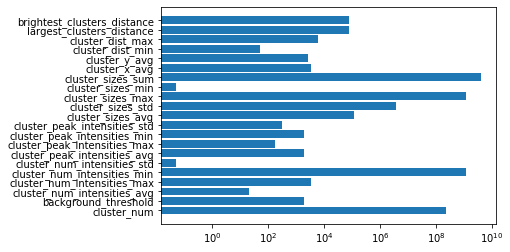

In [171]:
feature_var = X.var(axis=0)
print(list(range(feature_var.shape[0])))
print(feature_var)
plt.barh(list(range(feature_var.shape[0])), feature_var, tick_label=df_X.columns[:-1].values, log=True)

### Mutual information test

<BarContainer object of 21 artists>

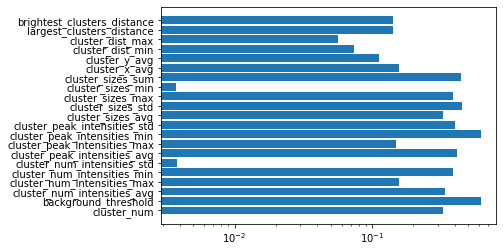

In [172]:
scaler = StandardScaler(with_std=True)
X = scaler.fit_transform(X)
mi = mutual_info_regression(X, y)
plt.barh(list(range(mi.shape[0])), mi, tick_label=df_X.columns[:-1].values, log=True)

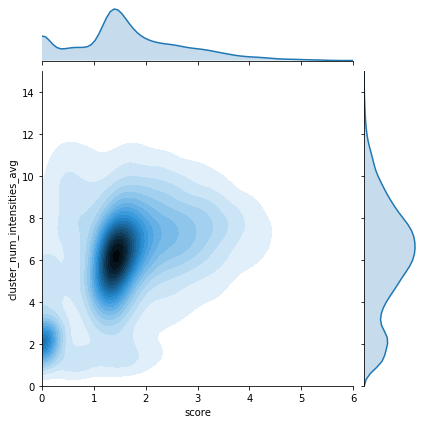

In [92]:
sns.jointplot(x='score', y='cluster_num_intensities_avg', data=df_X, kind='kde', xlim=(0, 6), ylim=((0, 15)), 
                   joint_kws={'n_levels': 20, 'shade': True, 'shade_lowest': False})

### Cluster peak intensity average
Very predictive

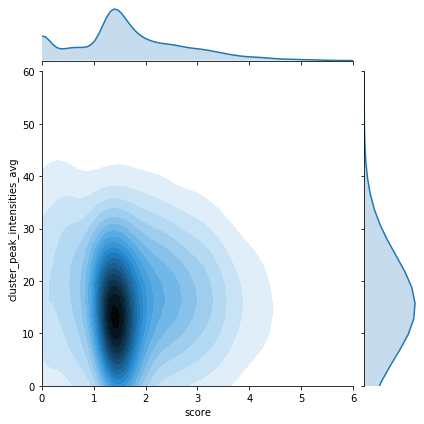

In [51]:
sns.jointplot(x='score', y='cluster_peak_intensities_avg', data=df_X, kind='kde', xlim=(0, 6), ylim=((0, 60)), 
                   joint_kws={'n_levels': 20, 'shade': True, 'shade_lowest': False})

### Cluster size average

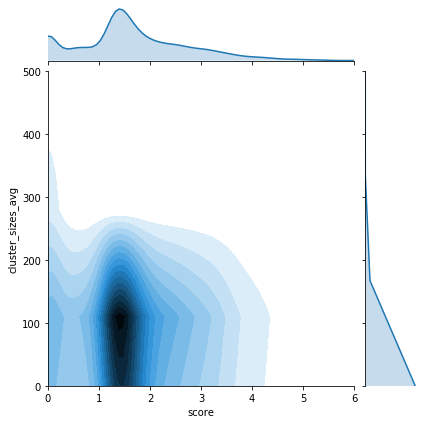

In [93]:
sns.jointplot(x='score', y='cluster_sizes_avg', data=df_X, kind='kde', xlim=(0, 6), ylim=((0, 500)), 
                   joint_kws={'n_levels': 20, 'shade': True, 'shade_lowest': False})

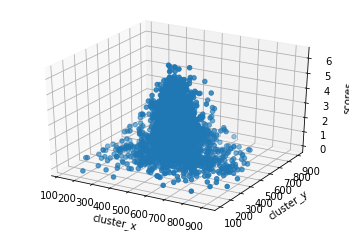

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(cluster_x_avg, cluster_y_avg, scores_avg)
ax.set_xlabel('cluster_x')
ax.set_ylabel('cluster_y')
ax.set_zlabel('scores')
plt.show()

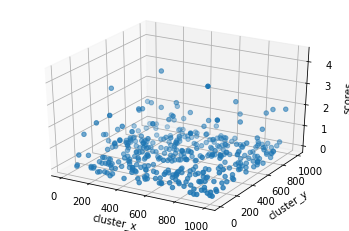

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(cluster_x_samples, cluster_y_samples, scores_sample)
ax.set_xlabel('cluster_x')
ax.set_ylabel('cluster_y')
ax.set_zlabel('scores')
plt.show()

In [173]:
df_y = df_X['score']
df_X.drop(columns=['score'], inplace=True)
df_X.to_csv('train_X.csv', index=False)
df_y.to_csv('train_y.csv', index=False)

**Preparing data for query**

No need to run - test_df.csv is already uploaded on Git

In [ ]:
test_X = extract_all_information_query(os.path.join('..', 'data','query'))

In [ ]:
test_df = to_df_query(test_X)
test_df.to_csv('test_df.csv')
test_df.head()

### Pre-compute and save the test features

In [100]:
test_df = pd.read_csv('test_df.csv')
# pd saves lists as strings, so we need to convert them to lists manually
test_df.cluster_sizes = test_df.cluster_sizes.swifter.apply(ast.literal_eval)
test_df.cluster_centers = test_df.cluster_centers.swifter.apply(ast.literal_eval)
test_df.cluster_peak_intensities = test_df.cluster_peak_intensities.swifter.apply(ast.literal_eval)
test_df.cluster_num_intensities = test_df.cluster_num_intensities.swifter.apply(ast.literal_eval)

assert type(test_df.cluster_sizes.tolist()[0]) == list

In [102]:
del test_df['Unnamed: 0']
test_df.head(5)

,background_threshold,cluster_num,cluster_sizes,cluster_peak_intensities,cluster_num_intensities,cluster_centers
0,0,94,"[6, 20, 109, 1, 8, 2, 4, 3, 57, 8, 32, 4, 5, 2...","[1, 3, 111, 1, 1, 1, 1, 1, 22, 1, 4, 1, 1, 1, ...","[1, 3, 36, 1, 1, 1, 1, 1, 17, 1, 4, 1, 1, 1, 2...","[(1, 39), (5, 295), (30, 107), (25, 286), (46,..."
1,187,20943,"[69, 1, 70, 4, 381, 111, 73, 70, 1, 16, 41, 26...","[254, 191, 254, 242, 254, 251, 251, 250, 219, ...","[33, 1, 36, 4, 62, 41, 37, 34, 1, 14, 22, 18, ...","[(1, 10), (0, 18), (2, 25), (1, 41), (17, 56),..."
2,0,64,"[4, 82, 11, 7, 2, 40, 102, 160, 3, 6, 7, 54, 3...","[1, 4, 2, 5, 1, 5, 85, 251, 1, 2, 1, 29, 1, 1,...","[1, 4, 2, 4, 1, 5, 34, 54, 1, 2, 1, 17, 1, 1, ...","[(0, 906), (19, 900), (61, 728), (130, 428), (..."
3,3,50,"[197, 9, 19, 59, 5, 10, 45, 18, 35, 84, 19, 20...","[26, 4, 7, 7, 4, 4, 19, 4, 13, 9, 6, 46, 49, 4...","[19, 1, 4, 4, 1, 1, 12, 1, 9, 6, 3, 30, 23, 1,...","[(17, 159), (22, 965), (50, 794), (101, 387), ..."
4,2,57,"[12, 16, 8, 120, 11, 14, 8, 25, 8, 5, 5, 7, 85...","[4, 3, 3, 5, 3, 3, 3, 6, 3, 3, 3, 3, 69, 255, ...","[2, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 28, 89, 1...","[(7, 567), (10, 67), (18, 448), (37, 14), (36,..."


In [105]:
test_features_df = get_features(test_df, score=False)
test_features_df.to_csv('test_X.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:01<00:00, 704.60it/s]
